# load data

In [1]:
import os
os.chdir('/rds/general/user/ma11115/home/Geom3D/Geom3D/')
#os.chdir('C:/Users/ma11115/OneDrive - Imperial College London/Geom3d/Geom3D/')

In [2]:
#from geom3d.test_train import *
from geom3d.oligomer_encoding_with_transformer import Fragment_encoder
from geom3d.models import SchNet

import torch
import copy
config_dir = os.getcwd()+"/training/SchNet_Trans_80K"

In [3]:
from geom3d.utils.config_utils import read_config
from geom3d.train_models import Pymodel

config = read_config(config_dir)
pymodel = Pymodel.load_from_checkpoint(config["model_embedding_chkpt"])
model_config = config["model"]
model = SchNet(
    hidden_channels=model_config["emb_dim"],
    num_filters=model_config["SchNet_num_filters"],
    num_interactions=model_config["SchNet_num_interactions"],
    num_gaussians=model_config["SchNet_num_gaussians"],
    cutoff=model_config["SchNet_cutoff"],
    readout=model_config["SchNet_readout"],
    node_class=model_config["node_class"],
)
EncodingModel = Fragment_encoder(
    input_dim = config["emb_dim"]*config["number_of_fragement"],
    model_dim=config["emb_dim"],
    num_heads=1,
    num_classes=model_config["emb_dim"],
    num_layers=1,
    dropout=0.0,
    lr=5e-4,
    warmup=50,
    max_iters=config["max_epochs"] ,
)

EncodingModel.add_encoder(model)
state_dict = torch.load(config["model_transformer_chkpt"],map_location=torch.device('cpu'))
EncodingModel.load_state_dict(state_dict['state_dict'])

config loaded from /rds/general/user/ma11115/home/Geom3D/Geom3D/training/SchNet_Trans_80K


<All keys matched successfully>

In [4]:
from geom3d.dataloader import load_data_frag,load_data
import numpy as np
pymodel.freeze()
config["device"] = "cpu" #"cuda:0" if torch.cuda.is_available() else "cpu"
pymodel.to(config["device"] )
model_embedding = pymodel.molecule_3D_repr

    
np.random.seed(config["seed"])
torch.cuda.manual_seed_all(config["seed"])


In [5]:
dataset_frag = load_data_frag(config)
dataset = load_data(config)

loading dataset from /rds/general/user/ma11115/home/Geom3D/Geom3D/training/SchNet_Trans_80K_frag_transf_6/dataset_frag.pt


In [6]:
# test model inference on a single molecule
from torch_geometric.data import Batch
data = dataset[:100]
data = [x.to(config["device"]) for x in data]
def predict_target(data):
    data = Batch.from_data_list(data)
    pymodel.eval()
    with torch.no_grad():
        out = pymodel(data)
    #print('y_pred is ',out)
    #print('y_true is ',data.y)
    L1 = out.squeeze()-data.y
    print('loss is ',L1.abs().mean())
    return out.squeeze(), data.y

def predict_target_frag(data):
    data = Batch.from_data_list(data)
    pymodel.eval()
    with torch.no_grad():
        out = pymodel(data)
    #print('y_pred is ',out)
    #print('y_true is ',data.y)
    L1 = out.squeeze()-data.y
    print('loss is ',L1.abs().mean())
    return out.squeeze(), data.y


predict_target(data)

loss is  tensor(1.1330)


(tensor([ -9.4689,  -9.1613,  -9.1511,  -9.4180, -10.2174,  -8.9145,  -9.3624,
          -9.4735, -10.3601,  -9.0447, -10.1044,  -9.3437,  -8.8900,  -9.1136,
          -9.2046,  -9.8815,  -9.5165,  -9.9752,  -9.4654,  -9.7449,  -8.7217,
          -9.8770,  -9.2760,  -8.9209, -10.1304,  -9.8072,  -9.3592,  -8.6166,
          -9.7733, -10.7106,  -9.5692, -10.5443,  -9.5408,  -9.8295,  -9.7361,
          -8.4049, -10.0235,  -9.7643,  -8.3915,  -9.7288,  -8.6105,  -9.6600,
          -9.9385,  -9.5389,  -9.0677,  -9.8227,  -8.6903, -10.3178,  -9.2137,
          -9.8630,  -9.8907,  -9.9337,  -9.9226,  -8.2751,  -9.7975,  -9.9446,
          -9.7834,  -9.5014,  -9.8009, -10.0525, -10.6548,  -9.2292,  -9.3842,
          -9.6741,  -8.3995,  -9.5059,  -9.8538,  -9.3332,  -8.5681,  -9.7306,
         -10.1602, -10.4152,  -9.8903,  -9.8414, -10.0577, -10.5032,  -9.9444,
          -9.5445, -10.3589,  -9.4511,  -9.2369,  -8.8541,  -9.9367,  -9.5678,
          -9.4996, -10.1117,  -9.7383,  -9.4697, -10

In [7]:
import numpy as np
import os
import pandas as pd
from stk_search import Database_utils
import stk_search
from botorch.models.gp_regression import SingleTaskGP
#from stk_search.tanimoto_kernel import TanimotoKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch import kernels
from stk_search.Search_algorithm import (
    Representation_slatm,
    RepresentationPrecursor,
)
from stk_search.Search_algorithm import Bayesian_Optimisation
from stk_search import Searched_space
from sklearn.decomposition import PCA

import torch
def load_data(df_path = "data/output/Full_datatset/df_total_new2023_08_20.csv",
                df_precursors_path = "data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl"):
    df_total, df_precursors = stk_search.Database_utils.load_data_from_file(
        df_path, df_precursors_path
    )
    SP = Searched_space.Searched_Space(
        number_of_fragments=6,
        df=df_precursors,
        features_frag=df_precursors.columns[0:1],
        generation_type="conditional",
    )
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
    fitness_acquired = searched_space_df["target"].values
    searched_space_df_InChIKey = searched_space_df[['InChIKey']]
    searched_space_df = searched_space_df[[f"InChIKey_{x}" for x in range(6)]]
    return df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey



In [8]:
"""
this script is to encode the representation of the oligomer from the representation of the fragments
"""
import numpy as np
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

class Representation3D:
    def __init__(self, model_embedding,df_results, data=None,db_poly=None,device=None):
        self.model_embedding = model_embedding
        self.model_embedding.eval()
        if device is None:
            self.device = ("cuda" if torch.cuda.is_available() else torch.device("cpu"))
        else:
            self.device = device

        self.model_embedding.to(self.device)
        self.df_inchikey = None
        self.df_total = df_results
        if data is not None:
            self.dataset = data
            if db_poly is not None:
                self.db_poly = db_poly
        elif db_poly is not None:
            self.db_poly = db_poly
            self.dataset = None
        else:
            raise ValueError("Please provide either data or db_poly")
    def generate_repr(self, elements):
        elements_copy = elements.copy()
        elements_copy = elements_copy.values
        InChIKeys = self._find_elem_InchiKey(elements_copy)
        molecules = []
        for x in InChIKeys:
            if self.dataset is not None:
                data = self.find_data(x)
                if data is not None:
                    data.to(self.device)
                    molecules.append(data)
                else:
                    molecules.append(self._getinfo_db(x))
            else:
                molecules.append(self._getinfo_db(x))
        with torch.no_grad():
            batch = Batch.from_data_list(molecules).to(self.device)
            opt_geom_encoding = self.model_embedding(batch.x, batch.positions, batch.batch)
        return opt_geom_encoding
    def _getinfo_db(self,InChIKey):
        polymer = self.db_poly.get({"InChIKey": InChIKey[0]})
        frags = []
        dat_list = list(polymer.get_atomic_positions())
        positions = np.vstack(dat_list)
        positions = torch.tensor(positions, dtype=torch.float, device=self.device)
        atom_types = list(
            [
                atom.get_atom().get_atomic_number()
                for atom in polymer.get_atom_infos()
            ]
        )
        atom_types = torch.tensor(atom_types, dtype=torch.long, device=self.device)
        molecule = Data(x=atom_types, positions=positions, device=self.device)
        return molecule

    def find_data(self, key):
        for i in range(len(self.dataset)):
            if self.dataset[i]["InChIKey"] == key:
                data = self.dataset[i].to(self.device)
                return Data(x=data.x, positions=data.positions, device=self.device)
        print("No data found in database")
        return None
    def _find_elem_InchiKey(self, elements):
        InChIKeys = []
        if self.df_inchikey is None:
            for elm in elements:
                df_search = self.df_total.copy()
                for i, x in enumerate(elm):
                    df_search = df_search[df_search[f"InChIKey_{i}"] == x]
                InChIKeys.append(df_search['InChIKey'].values.astype(str))
        else:
            InChIKeys = self.df_inchikey['InChIKey'].values.astype(str)
        return InChIKeys
    
class Representation3DFrag:
    def __init__(self, model_embedding,model_encoding,df_results, data=None,db_poly=None,db_frag=None):
        
        self.device = ("cuda" if torch.cuda.is_available() else torch.device("cpu"))
        self.model_embedding = model_embedding
        self.model_embedding.eval()
        self.model_embedding.to(self.device)
        self.model_encoding = model_encoding
        self.model_encoding.eval()
        self.model_encoding.to(self.device)
        self.df_inchikey = None
        self.df_total = df_results
        if data is not None:
            self.dataset = data
            if db_poly is not None:
                self.db_poly = db_poly
        elif db_poly is not None:
            self.db_poly = db_poly
        else:
            raise ValueError("Please provide either data or db_poly")
        self.db_frag = db_frag
    def generate_repr(self, elements):
        elements_copy = elements.copy()
        elements_copy = elements_copy.values
        #InChIKeys = self._find_elem_InchiKey(elements_copy)
        molecules = []
        for x in elements_copy:
            if self.dataset is not None:
                InChIKeys = self._find_elem_InchiKey([x])
                data = self.find_data(InChIKeys)
                if data is not None:
                    data.to(self.device)
                    molecules.append(data)
                else:
                    molecules.append(self._getinfo_db(x))
            else:
                molecules.append(self._getinfo_db(x))
        with torch.no_grad():
            batch = Batch.from_data_list(molecules).to(self.device)
            opt_geom_encoding = self.model_encoding(batch.x)
        return opt_geom_encoding
    def _getinfo_db(self,elements):
        frags = []
        for elm in elements:
            molecule_bb = self.db_frag.get({"InChIKey": elm})
            dat_list = list(molecule_bb.get_atomic_positions())
            positions = np.vstack(dat_list)
            positions = torch.tensor(positions, dtype=torch.float, device=self.device)
            atom_types = list(
                [atom.get_atomic_number() for atom in molecule_bb.get_atoms()]
            )
            atom_types = torch.tensor(atom_types, dtype=torch.long, device=self.device)
            molecule_frag = Data(
                x=atom_types,
                positions=positions,
                device=self.device,
            )
            frags.append(molecule_frag)
        # get the fragment based representation
        with torch.no_grad():
            self.model_embedding.eval()
            batch = Batch.from_data_list(frags).to(self.device)
            original_encoding = self.model_embedding(batch.x, batch.positions, batch.batch)
            original_encoding = original_encoding.reshape((-1,))
            original_encoding = original_encoding.unsqueeze(0)
        return Data(x=original_encoding)


    def find_data(self, key):
        for i in range(len(self.dataset)):
            if self.dataset[i]["InChIKey"] == key[0]:
                data = self.dataset[i].to(self.device)
                return Data(x=data.x)
        print("No data found in database")
        return None
    def _find_elem_InchiKey(self, elements):
        InChIKeys = []
        if self.df_inchikey is None:
            for elm in elements:
                df_search = self.df_total.copy()
                for i, x in enumerate(elm):
                    df_search = df_search[df_search[f"InChIKey_{i}"] == x]
                InChIKeys.append(df_search['InChIKey'].values.astype(str))
        else:
            InChIKeys = self.df_inchikey['InChIKey'].values.astype(str)
        return InChIKeys
import time

class Representation3DFrag_transformer:
    def __init__(self, model_encoding,df_results, data=None,db_poly=None,db_frag=None,device=None):
        if device is None:
            self.device = ("cuda" if torch.cuda.is_available() else torch.device("cpu"))
        else:
            self.device = device
        self.model_encoding = model_encoding
        self.model_encoding.eval()
        self.model_encoding.to(self.device)
        self.df_inchikey = None
        self.df_total = df_results
        if data is not None:
            self.dataset = data
            if db_poly is not None:
                self.db_poly = db_poly
        elif db_poly is not None:
            self.dataset = None
            self.db_poly = db_poly
        else:
            raise ValueError("Please provide either data or db_poly")
        self.db_frag = db_frag
    def generate_repr(self, elements):
        elements_copy = elements.copy()
        elements_copy = elements_copy.values
        #InChIKeys = self._find_elem_InchiKey(elements_copy)
        molecules = []
        start_time = time.time()
        for x in elements_copy:
            if self.dataset is not None:
                InChIKeys = self._find_elem_InchiKey([x])
                data = self.find_data(InChIKeys)
                if data is not None:
                    data.to(self.device)
                    molecules.append(data)
                else:
                    molecules.append(self._getinfo_db(x))
            else:
                molecules.append(self._getinfo_db(x))
        time_taken = time.time() - start_time
        print(f"Time taken to get the data is {time_taken}")
        with torch.no_grad():
            opt_geom_encoding = []
            #data_loader = DataLoader(molecules, batch_size=min(100,len(molecules))) # need to check how to use batches
            for batch in molecules:#data_loader:
                encoding = self.model_encoding(batch)
                opt_geom_encoding.append(encoding[0][0])
        time_taken = time.time() - time_taken-start_time
        print(f"Time taken to run embedding is {time_taken}")
        return torch.stack(opt_geom_encoding)
    def _getinfo_db(self,elements):
        frags = []
        for elm in elements:
            molecule_bb = self.db_frag.get({"InChIKey": elm})
            dat_list = list(molecule_bb.get_atomic_positions())
            positions = np.vstack(dat_list)
            positions = torch.tensor(positions, dtype=torch.float, device=self.device)
            atom_types = list(
                [atom.get_atomic_number() for atom in molecule_bb.get_atoms()]
            )
            atom_types = torch.tensor(atom_types, dtype=torch.long, device=self.device)

            molecule_frag = Data(
                x=atom_types,
                positions=positions,
                device=self.device,
            )
            frags.append(molecule_frag)
        return frags


    def find_data(self, key):
        for i in range(len(self.dataset)):
            if self.dataset[i][0]["InChIKey"] == key[0]:
                data = self.dataset[i].to(self.device)
                return Data(x=data.x)
        print("No data found in database")
        return None
    def _find_elem_InchiKey(self, elements):
        InChIKeys = []
        if self.df_inchikey is None:
            for elm in elements:
                df_search = self.df_total.copy()
                for i, x in enumerate(elm):
                    df_search = df_search[df_search[f"InChIKey_{i}"] == x]
                InChIKeys.append(df_search['InChIKey'].values.astype(str))
        else:
            InChIKeys = self.df_inchikey['InChIKey'].values.astype(str)
        return InChIKeys
'''
def generate_repr_data(df_path = df_path,
                df_precursors_path = df_precursors_path):
    #loa
    df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)



    BO = Bayesian_Optimisation.Bayesian_Optimisation()
    BO.Representation = Representation3D(model_embedding,df_total,data=dataset)
    BO.verbose = True
    X_explored = BO.Representation.generate_repr(searched_space_df)
        # limit the dataframe to only the numeric data
    y_explored = torch.tensor(
        fitness_acquired, dtype=torch.float32, device=BO.device
    )
    return BO, X_explored, y_explored
'''


'\ndef generate_repr_data(df_path = df_path,\n                df_precursors_path = df_precursors_path):\n    #loa\n    df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)\n\n\n\n    BO = Bayesian_Optimisation.Bayesian_Optimisation()\n    BO.Representation = Representation3D(model_embedding,df_total,data=dataset)\n    BO.verbose = True\n    X_explored = BO.Representation.generate_repr(searched_space_df)\n        # limit the dataframe to only the numeric data\n    y_explored = torch.tensor(\n        fitness_acquired, dtype=torch.float32, device=BO.device\n    )\n    return BO, X_explored, y_explored\n'

In [9]:
#find data in dataset with a specific InChI key
from pathlib import Path
df_path = Path(
        config["STK_path"], "data/output/Full_dataset/", config["df_total"]
    )
df_precursors_path = Path(
    config["STK_path"],
    "data/output/Prescursor_data/",
    config["df_precursor"],
)
df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)

In [10]:
config = read_config(config_dir)
graph_pred_linear = torch.nn.Linear(
        model_config["emb_dim"], model_config["num_tasks"]
    )
model_config = config["model"]
model = SchNet(
    hidden_channels=model_config["emb_dim"],
    num_filters=model_config["SchNet_num_filters"],
    num_interactions=model_config["SchNet_num_interactions"],
    num_gaussians=model_config["SchNet_num_gaussians"],
    cutoff=model_config["SchNet_cutoff"],
    readout=model_config["SchNet_readout"],
    node_class=model_config["node_class"],
)
pymodel = Pymodel(model, graph_pred_linear)
state_dict = torch.load(config["model_embedding_chkpt"],map_location=torch.device('cuda:0'))
pymodel.load_state_dict(state_dict['state_dict'])

EncodingModel = Fragment_encoder(
    input_dim = config["emb_dim"]*config["number_of_fragement"],
    model_dim=config["emb_dim"],
    num_heads=1,
    num_classes=model_config["emb_dim"],
    num_layers=1,
    dropout=0.0,
    lr=5e-4,
    warmup=50,
    max_iters=config["max_epochs"] ,
)

EncodingModel.add_encoder(model)
state_dict = torch.load(config["model_transformer_chkpt"],map_location=torch.device('cpu'))
EncodingModel.load_state_dict(state_dict['state_dict'])
#EncodingModel.state_dict()

config loaded from /rds/general/user/ma11115/home/Geom3D/Geom3D/training/SchNet_Trans_80K


<All keys matched successfully>

In [13]:
#df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)
import pymongo
import stk
BO = Bayesian_Optimisation.Bayesian_Optimisation()
client = pymongo.MongoClient(config["pymongo_client"])
db_poly = stk.ConstructedMoleculeMongoDb(
    client,
    database=config["database_name"],
)
db_frag = stk.MoleculeMongoDb(
    client,
    database=config["database_name"],
)
#get indices of fitness values in each bin
bins = np.linspace(-12,0,1000)
inds = []
for i in range(len(bins)-1):
    inds.append(np.where((fitness_acquired>=bins[i]) & (fitness_acquired<bins[i+1]))[0])
for i in range(len(inds)):
    if len(inds[i])>0:
        inds[i] = np.random.choice(inds[i],size=1)
inds = np.concatenate(inds)
#model_encoding = EncodingModel.encoder
BO = Bayesian_Optimisation.Bayesian_Optimisation()
BO.device = torch.device('cpu')
BO.Representation = Representation3DFrag_transformer(EncodingModel,df_total,db_poly=db_poly,db_frag=db_frag,device=BO.device)
BO.verbose = True

X_explored_frag = BO.Representation.generate_repr(searched_space_df.iloc[inds])



Time taken to get the data is 2.757021427154541
Time taken to run embedding is 49.61947059631348


In [14]:
# generate orginal representation
BO.device = torch.device('cuda:0')
BO.Representation = Representation3D(model_embedding,df_total,data=None,db_poly=db_poly,device=BO.device)
X_explored_org = BO.Representation.generate_repr(searched_space_df.iloc[inds])
print(X_explored_frag.shape)

torch.Size([847, 128])


# test simple GP

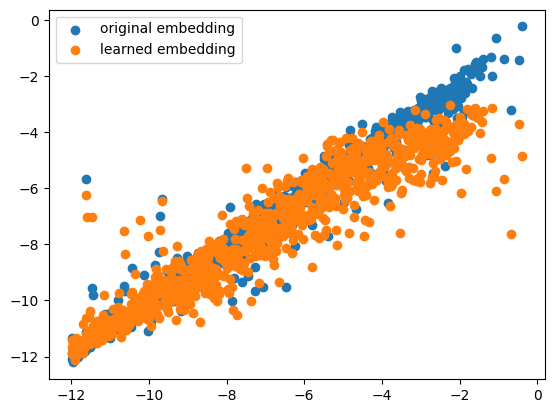

In [15]:
%matplotlib inline
BO.device = torch.device('cpu')
y_explored = torch.tensor(
            fitness_acquired[inds], dtype=torch.float32, device=BO.device
        )
def PredictTargetFromEmbedding(data):
    data= data.to(BO.device)
    model = pymodel.graph_pred_linear.to(BO.device)
    model.eval()
    with torch.no_grad():
        out = model(data)
    return out.squeeze()

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_explored.cpu().numpy(),PredictTargetFromEmbedding(X_explored_org).cpu().numpy(),label='original embedding')
ax.scatter(y_explored.cpu().numpy(),PredictTargetFromEmbedding(X_explored_frag).cpu().numpy(),label='learned embedding')
ax.legend()
#y_explored = PredictTargetFromEmbedding(X_explored)


Training size tensor([0.4729], dtype=torch.float64)
Training size torch.Size([423, 128])


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.4308], dtype=torch.float64), std = tensor([0.2597], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Training size tensor([0.4943], dtype=torch.float64, grad_fn=<SelectBackward0>)
R2 score: 0.96
MSE score: 0.02
MAE score: 0.09
R2 score: 0.98
MSE score: 0.01
MAE score: 0.06


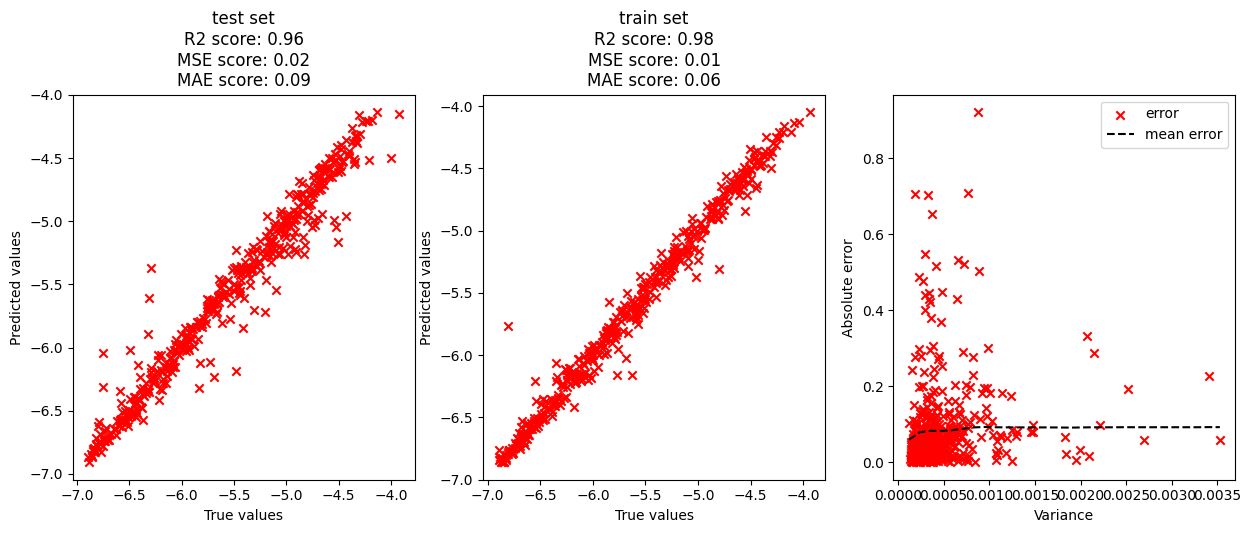

In [17]:
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import kernels

from stk_search.Search_algorithm.tanimoto_kernel import TanimotoKernel
from stk_search.Search_algorithm import Bayesian_Optimisation
import importlib
importlib.reload(Bayesian_Optimisation)
BO = Bayesian_Optimisation.Bayesian_Optimisation()
test_set_size =0.5
test_model_dict = []
count = 0
case =""

# We define our custom GP surrogate model using the Tanimoto kernel
class TanimotoGP(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class MaternKernel(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=kernels.MaternKernel()
        )  # kernels.RBFKernel())#)
        self.to(train_X)  # make sure we're on the right device/dtype

    def change_kernel(self, kernel):
        self.covar_module = ScaleKernel(base_kernel=kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

def run_training_BO_torch(
    BO, test_set_size, X_explored,y_explored
):
    def normalise_input( X_list: list[torch.tensor]):
        X_all = torch.cat(X_list)
        X_list_norm = []
        for i, X in enumerate(X_list):
            X = X[:, X_all.std(axis=0) != 0]
            X_list_norm.append((X - X_all.mean(axis=0)) / X_all.std(axis=0))
        return X_list_norm

    def unnorm_output(y,y_mean,y_std):
            y = y*y_std+y_mean
            return y
    BO.kernel = TanimotoGP

    
    # %%
    (
    X_train,
    X_test,
    y_train,
    y_test,
    y_mean,
    y_std,
    ) = BO.train_test_split(
        X_explored,
        y_explored,
        test_set_size=test_set_size,
        random_state=42,
    )
    #[X_train,X_test]=normalise_input([X_train, X_test])
    data = {
        "X_train": X_train.cpu(),
        "X_test": X_test.cpu(),
        "y_train": y_train,
        "y_test": y_test,
    }
    print("Training size", y_train[0])
    print("Training size", data["X_train"].shape)
    (
        y_pred,
        y_var,
        y_pred_train,
        y_var_train,
    ) = BO.test_model_prediction(
        data["X_train"],
        data["y_train"],
        data["X_test"],
    )
    print("Training size", y_pred_train[0])
    fig_name = (
        f"trainsize_"
        + str(data["X_train"].shape[0])
        + "_testSi_"
        + str(data["X_test"].shape[0])
        + "_botorch.png"
    )
    
    y_pred = unnorm_output(y_pred, y_mean, y_std)
    y_pred_train = unnorm_output(y_pred_train, y_mean, y_std)
    y_test = unnorm_output(y_test, y_mean, y_std)
    y_train = unnorm_output(y_train, y_mean, y_std)
    scores_test, scores_train = BO.plot_prediction(
        y_pred,
        y_test,
        y_pred_train,
        y_train,
        y_var,
        save_plot=True,
        plot_name=fig_name,
    )
    return y_pred_train, y_pred

%matplotlib inline
data = run_training_BO_torch(
                        BO, test_set_size,  X_explored_org,y_explored
                    )


Training size tensor([0.4729], dtype=torch.float64)
Training size torch.Size([423, 128])


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.4308], dtype=torch.float64), std = tensor([0.2597], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Training size tensor([0.5346], dtype=torch.float64, grad_fn=<SelectBackward0>)
R2 score: 0.89
MSE score: 0.06
MAE score: 0.17
R2 score: 0.92
MSE score: 0.05
MAE score: 0.15


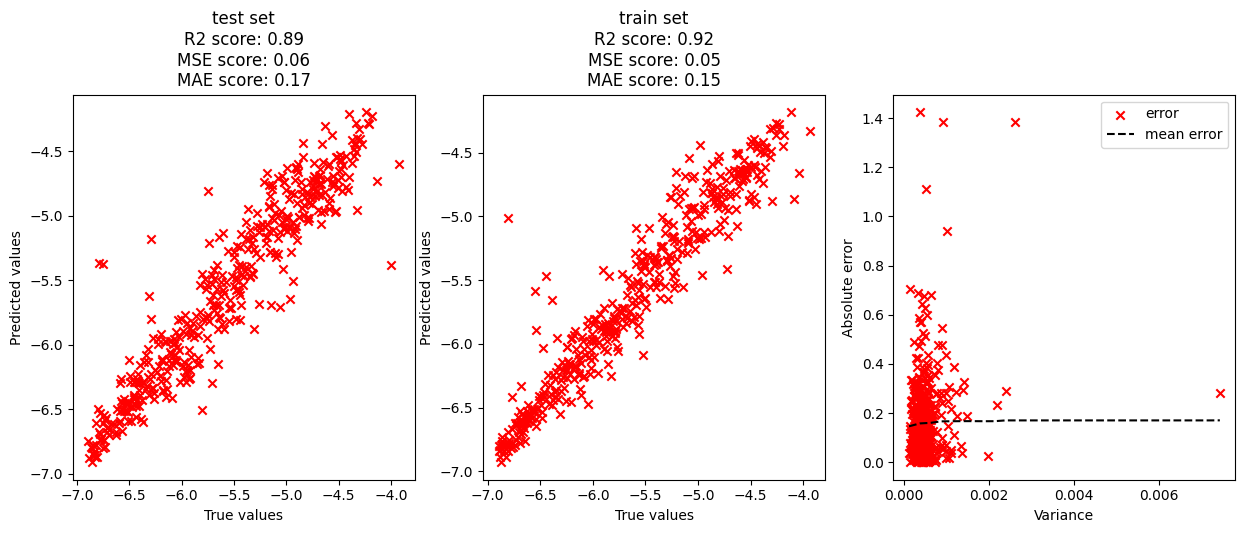

In [18]:
data = run_training_BO_torch(
                        BO, test_set_size,  X_explored_frag,y_explored
                    )

# test Deep kernel


In [ ]:
import gpytorch
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self,train_x, train_y, likelihood, feature_extractor):
            super(GPRegressionModel, self).__init__(train_x, train_y,likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel( likelihood,pymodel.molecule_3D_repr)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()